In [1]:
# import required packages
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Compose, ToTensor, transforms, Normalize
from torch import nn, optim
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [2]:
# read the dataset
dftrain = pd.read_csv("train.csv")
dftest = pd.read_csv("test.csv")
submission_keras = pd.read_csv("sample_submission.csv")
submission_pytorch = pd.read_csv("sample_submission.csv")

In [3]:
# split train and test data into input and output values
in_train = dftrain.loc[:, dftrain.columns!= "label"].values
out_train = dftrain["label"].values
in_test = dftest.values
in_train.shape, out_train.shape, in_test.shape

((42000, 784), (42000,), (28000, 784))

In [4]:
# reshape data in 2 dimensions (height and width)
in_train = in_train.reshape(-1, 28, 28) 
in_test = in_test.reshape(-1, 28, 28)

## Exploratory Data Analysis



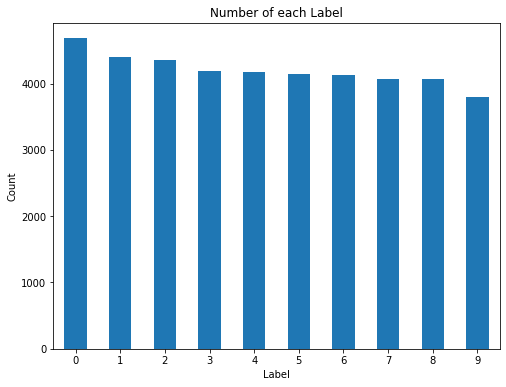

In [5]:
# Distribution of digits in training data
ax = dftrain["label"].value_counts().plot(kind='bar', figsize=(8,6), title="Number of each Label")
ax.set_xlabel("Label")
ax.set_ylabel("Count")

# set x ticks
nums = [0, 1, 2,3,4,5,6,7,8,9]
ax.set_xticklabels(nums, rotation=0)
plt.show()

How many rows of training images would you like to review? 3


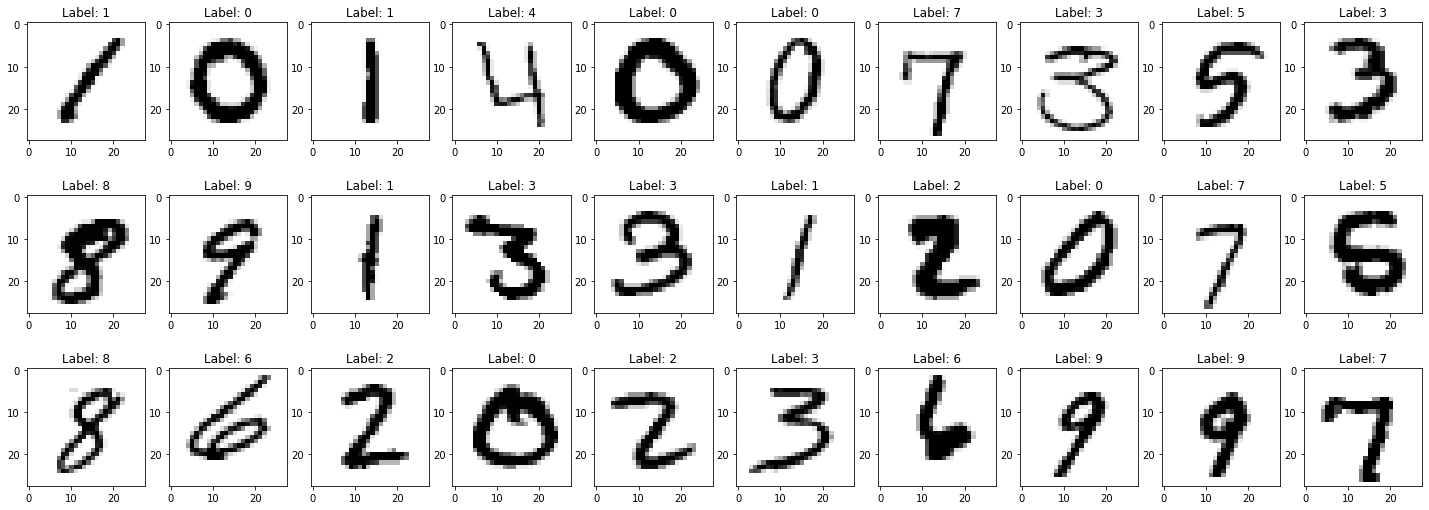

In [6]:
# Prompt the user "How many rows of training images would you like to review?"
rows = int(input("How many rows of training images would you like to review? "))

fig, axes = plt.subplots(rows, 10, figsize=(25, rows * 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(in_train[i], cmap='binary')
    digit = out_train[i]
    ax.set(title = f'Label: {digit}')

## Keras model

In [7]:
random.seed(5)
model = keras.Sequential(layers=[
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(200, activation="relu"), #increased dense layer relu size 
    keras.layers.Dense(45, activation="softmax")#increased dense layer softmax size 
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#changed batch and epochs to 80
model.fit(in_train, out_train, batch_size=80, epochs=80, validation_split=0.2)

Epoch 1/80
420/420 [==============================] - 3s 6ms/step - loss: 5.6835 - accuracy: 0.8710 - val_loss: 1.8210 - val_accuracy: 0.9182
Epoch 2/80
420/420 [==============================] - 2s 6ms/step - loss: 1.3213 - accuracy: 0.9327 - val_loss: 1.3768 - val_accuracy: 0.9315
Epoch 3/80
420/420 [==============================] - 2s 6ms/step - loss: 0.7407 - accuracy: 0.9510 - val_loss: 0.8799 - val_accuracy: 0.9437
Epoch 4/80
420/420 [==============================] - 2s 6ms/step - loss: 0.4466 - accuracy: 0.9615 - val_loss: 0.8296 - val_accuracy: 0.9452
Epoch 5/80
420/420 [==============================] - 2s 6ms/step - loss: 0.3516 - accuracy: 0.9654 - val_loss: 0.8352 - val_accuracy: 0.9469
Epoch 6/80
420/420 [==============================] - 2s 6ms/step - loss: 0.2514 - accuracy: 0.9729 - val_loss: 0.7348 - val_accuracy: 0.9523
Epoch 7/80
420/420 [==============================] - 2s 6ms/step - loss: 0.2456 - accuracy: 0.9724 - val_loss: 0.7559 - val_accuracy: 0.9458
Epoch 

In [8]:
# predict the test set
preds = model.predict(in_test).argsort()[:,-1]
print(preds)

[2 0 9 ... 3 9 2]


In [9]:
# put prediction in submission file
for i in range(len(preds)):
  submission_keras['Label'][i] = preds[i]

# save as csv file to sumbit
submission_keras.to_csv("submission_keras.csv", index=False)

## Visualizing test result

How many rows of testing images would you like to review? 1


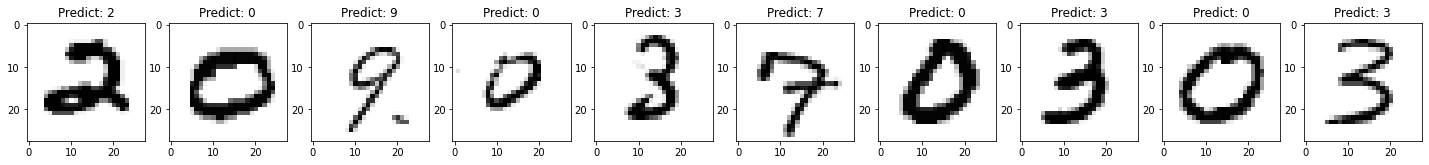

In [10]:
# Prompt the user "How many rows of testing images would you like to review?"
rows = int(input("How many rows of testing images would you like to review? "))

fig, axes = plt.subplots(rows, 10, figsize=(25, rows * 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(in_test[i], cmap='binary')
    digit = preds[i]
    ax.set(title = f'Predict: {digit}')

## PyTorch model

In [11]:
# Split data into training and validation part
# used https://pytorch.org/docs/stable/data.html for PyTorch model code
in_train, in_valid, out_train, out_valid = train_test_split(in_train, out_train, test_size=0.2)

In [12]:
# Normalize data
in_train_tensor = torch.tensor(in_train) / 255.0
out_train_tensor = torch.tensor(out_train)
train_tensor = TensorDataset(in_train_tensor, out_train_tensor)

in_valid_tensor = torch.tensor(in_valid) / 255.0
out_valid_tensor = torch.tensor(out_valid)
val_tensor = TensorDataset(in_valid_tensor, out_valid_tensor)

test_tensor = torch.tensor(in_test) / 255.0

In [13]:
# set batch size to 20
batch = 20
torch.manual_seed(20742)
load_train = DataLoader(train_tensor, batch_size=batch, shuffle=False)
torch.manual_seed(20742)
load_valid = DataLoader(val_tensor, batch_size=batch, shuffle=False)
load_test = DataLoader(test_tensor, batch_size=batch, shuffle=False)

In [14]:
# create a sequential model of one hidden layer
input_size = 28 * 28
hidden_size = 500
output_size = 10
model = nn.Sequential(
  nn.Linear(input_size, hidden_size), 
  nn.Sigmoid(), 
  nn.Linear(hidden_size, output_size), 
  nn.Softmax(dim=1)) 
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=500, out_features=10, bias=True)
  (3): Softmax(dim=1)
)


In [15]:
# train the model
torch.manual_seed(20742)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # implement Adam algorithm with learning rate
error = nn.CrossEntropyLoss() # this criterion computes the cross entropy loss between input and target
epochs = 50
for epoch in range(epochs):
  running_loss = 0
  for images, labels in load_train:
    train = images.view(images.shape[0], -1) # flatten image into a 784 vector
    outputs = model(train)
    loss = error(outputs, labels)
    optimizer.zero_grad() # training pass
    loss.backward() # learn by backpropagation
    optimizer.step() # optimize weights
    running_loss += loss.item()
  else:
    total = 0
    correct = 0
    for images, labels in load_train:
      train = images.view(images.shape[0], -1) # flatten image into a 784 vector
      outputs = model(train)
      predictions = torch.max(outputs, 1)[1]
      correct += (predictions == labels).sum()
      total += len(labels)
    print(f'Epoch {epoch + 1}/{epochs} - loss: {running_loss / total} - accuracy: {correct / total}')

Epoch 1/50 - loss: 0.08357831793881598 - accuracy: 0.928511917591095
Epoch 2/50 - loss: 0.07676229314435096 - accuracy: 0.9448809623718262
Epoch 3/50 - loss: 0.07583037934132984 - accuracy: 0.9558928608894348
Epoch 4/50 - loss: 0.07527250507402988 - accuracy: 0.9662797451019287
Epoch 5/50 - loss: 0.07490062193856353 - accuracy: 0.9716071486473083
Epoch 6/50 - loss: 0.0746244574870382 - accuracy: 0.9741666913032532
Epoch 7/50 - loss: 0.07440443009847686 - accuracy: 0.9740476012229919
Epoch 8/50 - loss: 0.07424514873751573 - accuracy: 0.9802976250648499
Epoch 9/50 - loss: 0.07411175912689595 - accuracy: 0.9816071391105652
Epoch 10/50 - loss: 0.07397600672784306 - accuracy: 0.980863094329834
Epoch 11/50 - loss: 0.07389312152706441 - accuracy: 0.9853273630142212
Epoch 12/50 - loss: 0.07381522441194172 - accuracy: 0.9864583611488342
Epoch 13/50 - loss: 0.07374143992861112 - accuracy: 0.9877678751945496
Epoch 14/50 - loss: 0.07368763332210836 - accuracy: 0.9880059361457825
Epoch 15/50 - loss

In [16]:
# calculate the accuracy for validation data set
count = 0
correct = 0
for images, labels in load_valid:
  test = images.view(images.shape[0], -1) # flatten image into a 784 vector
  with torch.no_grad():
    probs = model(test)
    preds = torch.max(probs, 1)[1]
  correct += (preds == labels).sum()
  count += len(labels)
print(f'Tested {count} images - accuracy: {correct / count}')

Tested 8400 images - accuracy: 0.9764285683631897


## Prediction on test data

In [17]:
# create an empty list to record the prediction label
label = []
for images in load_test:
  test = images.view(images.shape[0], -1) # flatten image into a 784 vector
  with torch.no_grad():
    probs = model(test)
    preds = torch.max(probs, 1)[1]
  label.append(preds)

In [18]:
# Create an empty list to make an one dimension model
flat_label = []

for i in label:
    # appending elements to the flat_label
    flat_label += i

In [19]:
# put prediction in submission file
for i in range(len(flat_label)):
  submission_pytorch['Label'][i] = flat_label[i]

# save as csv file to sumbit
submission_pytorch.to_csv("submission_pytorch.csv", index=False)